<a href="https://colab.research.google.com/github/thdefn/AIproj2022/blob/master/1130_genCNN_(ver_small_param).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [ ]:
X_valid = np.load('/kaggle/input/myimggen/X_valid_128.npy',allow_pickle=True)
y_valid = np.load('/kaggle/input/myimggen/y_valid_128.npy',allow_pickle=True)
X_train = np.load('/kaggle/input/myimggen/X_train_128.npy',allow_pickle=True)
y_train = np.load('/kaggle/input/myimggen/y_train_128.npy',allow_pickle=True)
X_test = np.load('/kaggle/input/myimggen/X_test_128.npy',allow_pickle=True)
y_test = np.load('/kaggle/input/myimggen/y_test_128.npy',allow_pickle=True)


X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [ ]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE
t = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
k = ImageDataGenerator()
valid_gen = t.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_gen = t.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_ngen = k.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_ngen = k.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('cnn_v2_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

2022-11-30 02:39:43.569471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 02:39:43.746663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 02:39:43.747490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 02:39:43.749227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

In [ ]:
cnn.compile(
  optimizer= SGD(lr=0.01, momentum=0.9),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(train_gen, validation_data= valid_ngen, epochs= 100, verbose=1,  steps_per_epoch = TRAIN_STEPS,  callbacks = [reduceLR, early_stopping, checkpoint_ag])
cnn.save('CNN_1130.h5')

2022-11-30 02:39:46.833594: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-30 02:39:48.273261: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 31s 58ms/step - loss: 1.0117 - accuracy: 0.5274 - val_loss: 1.0017 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to cnn_v2_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 24s 59ms/step - loss: 1.0036 - accuracy: 0.5288 - val_loss: 1.0028 - val_accuracy: 0.5295

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 23s 56ms/step - loss: 1.0032 - accuracy: 0.5285 - val_loss: 1.0001 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/100
410/410 [==============================] - 24s 58ms/step - loss: 1.0021 - accuracy: 0.5285 - val_loss: 0.9980 - val_accuracy: 0.5295

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 23s 57ms/step - loss: 1.0017 - accuracy: 0.5292 - val_loss: 0.9985 - val_accuracy: 0.5295

Epoch 00005: val_accu

In [ ]:
general.history

{'loss': [1.0116947889328003,
  1.0036365985870361,
  1.0032192468643188,
  1.0021157264709473,
  1.0017062425613403,
  1.001389503479004,
  1.0014264583587646,
  1.001778483390808,
  0.9966471791267395,
  0.9907538890838623,
  0.9872516393661499,
  0.9850191473960876,
  0.9835494756698608,
  0.979779064655304,
  0.9818347096443176,
  0.9854801893234253,
  0.9802993535995483,
  0.9814149141311646,
  0.9784319400787354,
  0.9745917320251465,
  0.9774548411369324,
  0.9752150177955627,
  0.9726728200912476,
  0.9748819470405579,
  0.9683840870857239,
  0.977835476398468,
  0.9679787755012512,
  0.9681599140167236,
  0.969753086566925,
  0.9689934253692627,
  0.9653630256652832,
  0.9548631310462952,
  0.9462697505950928,
  0.9653288125991821,
  0.9745738506317139,
  0.967018723487854,
  0.9559400677680969,
  0.9481981992721558,
  0.9438416361808777,
  0.9391134977340698,
  0.9331541061401367,
  0.9359750747680664,
  0.9150583148002625,
  0.9032377004623413,
  0.9063002467155457,
  0.8980

In [ ]:
import pickle
with open('CNN_1130.pkl', 'wb') as f:
	pickle.dump(general.history, f, protocol=pickle.HIGHEST_PROTOCOL)

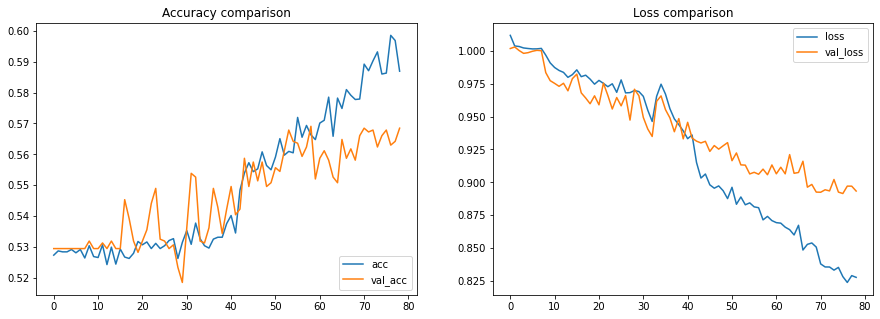

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(general.history['accuracy'], label='acc')
plt.plot(general.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(general.history['loss'], label='loss')
plt.plot(general.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [ ]:
y_test = np.array(y_test).astype(np.float32)
cnn.evaluate(X_test, y_test)

16/16 [==============================] - 0s 6ms/step - loss: 0.8543 - accuracy: 0.5859


[0.8542971014976501, 0.5859375]

In [ ]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [ ]:
y_pred_enc = cnn.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
        
res